In [1]:
import numpy.random as npr
import statsmodels.api as sm 
import scipy 
import numpy as np

from sklearn import linear_model
from sklearn.decomposition import PCA
from sklearn.datasets import make_spd_matrix
from scipy import stats
import matplotlib.pyplot as plt

from statsmodels.stats.outliers_influence import variance_inflation_factor



stats.chisqprob = lambda chisq, df: stats.chi2.sf(chisq, df)


In [2]:
# import time
# timenowseed = int(time.time())
# npr.seed(timenowseed)
# print(timenowseed)
npr.seed(1534727263)

In [3]:
n = 10000 # number of data points
d = 3 # number of causes (=2) + number of confounders (=1)

# A simulated dataset

## simulate correlated causes

In [4]:
def gen_normalU(n,d,Ucoef):
    U = npr.normal(size=(n,1))
    theta = npr.uniform(size=(1,d))
    Xmean = U.dot(theta)
    X = Xmean + npr.normal(np.zeros_like(Xmean))
#     np.corrcoef(X.T)
    # coef = np.array([0.2, 1.0, 0.9])
    coef = npr.uniform(size=d)
    assert len(coef) == d
    intcpt = npr.uniform(size=1)
    y = intcpt+coef.dot(X.T) + Ucoef*U[:,0] +npr.normal(size=n)
    return X, y, coef, intcpt

def gen_uniformU(n,d,Ucoef):
    U = npr.uniform(size=(n,1))
    theta = npr.uniform(size=(1,d))
    Xmean = U.dot(theta)
    X = Xmean + npr.normal(np.zeros_like(Xmean))
#     np.corrcoef(X.T)
    # coef = np.array([0.2, 1.0, 0.9])
    coef = npr.uniform(size=d)
    assert len(coef) == d
    intcpt = npr.uniform(size=1)
    y = intcpt+coef.dot(X.T) + Ucoef*U[:,0] +npr.normal(size=n)
    return X, y, coef, intcpt

In [5]:
def dcf(X, y):
    pca = PCA(n_components=1)
    pca.fit(X)
    Zhat = pca.transform(X)
    x2 = sm.add_constant(np.column_stack([X, Zhat]))
    models = sm.OLS(y,x2)
    result = models.fit()
#     print(result.summary())

#     variables = result.model.exog
#     vif = [variance_inflation_factor(variables, i) for i in range(variables.shape[1])]
#     print(vif) 
    
    mse = ((coef-result.params[1:(d+1)])**2).sum()
#     print(coef, result.params[1:(d+1)])
#     print(mse)
    return mse

In [6]:
def naive(X, y):
    x2 = sm.add_constant(X)
    models = sm.OLS(y,x2)
    result = models.fit()
#     print(result.summary())
    mse = ((coef-result.params[1:(d+1)])**2).sum()
#     print(mse)
#     print(result.params)
#     print(coef, result.params[1:(d+1)])
    return mse
    

In [7]:
def plot_dcf_naive(data_a, data_b, figname):
    ticks = ['0', '1', '2', '3', '4', '5']

    def set_box_color(bp, color):
        plt.setp(bp['boxes'], color=color)
        plt.setp(bp['whiskers'], color=color)
        plt.setp(bp['caps'], color=color)
        plt.setp(bp['medians'], color=color)

    plt.figure(figsize=(4,3))

    bpl = plt.boxplot(data_a, positions=np.array(range(len(data_a)))*2.0-0.4, sym='', widths=0.6)
    bpr = plt.boxplot(data_b, positions=np.array(range(len(data_b)))*2.0+0.4, sym='', widths=0.6)
    set_box_color(bpl, '#D7191C') # colors are from http://colorbrewer2.org/
    set_box_color(bpr, '#2C7BB6')

    # draw temporary red and blue lines and use them to create a legend
    plt.plot([], c='#D7191C', label='Deconfounder (PPCA)')
    plt.plot([], c='#2C7BB6', label='Naive regression')
    plt.legend()

    plt.xticks(range(0, len(ticks) * 2, 2), ticks)
    plt.xlim(-2, len(ticks)*2)
    plt.xlabel('confounding strength')
    plt.ylabel('MSE')
    # plt.ylim(0, 8)
    plt.tight_layout()
    plt.savefig(figname)

0
conf strength 0 prob(DCFmse < NAIVEmse) 0.0 avgDCFmse 0.17980596694910017 avgNAIVEmse 0.0002467213623805958
1
conf strength 1 prob(DCFmse < NAIVEmse) 0.98 avgDCFmse 0.04341848794845394 avgNAIVEmse 0.22326475624576816
2
conf strength 2 prob(DCFmse < NAIVEmse) 0.98 avgDCFmse 0.026540430563430042 avgNAIVEmse 0.9165752132785062
3
conf strength 3 prob(DCFmse < NAIVEmse) 1.0 avgDCFmse 0.13413150072466581 avgNAIVEmse 2.066279781802321
4
conf strength 4 prob(DCFmse < NAIVEmse) 1.0 avgDCFmse 0.34230449726061424 avgNAIVEmse 3.673362041419821
5
conf strength 5 prob(DCFmse < NAIVEmse) 1.0 avgDCFmse 0.7222902751912659 avgNAIVEmse 5.728371914063171


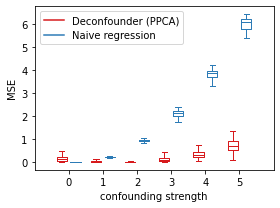

In [8]:
dcfs = []
naives = []
for Ucoef in [0,1,2,3,4,5]:
    print(Ucoef)
    dcferrs = []
    naiveerrs = []
    for _ in range(100):
        X, y, coef, intcpt = gen_normalU(n,d,Ucoef)
        dcferr = dcf(X, y)
        naiveerr = naive(X, y)
        dcferrs.append(dcferr)
        naiveerrs.append(naiveerr)
#         print(dcferr, naiveerr, dcferr<naiveerr)
    print("conf strength", Ucoef, \
          "prob(DCFmse < NAIVEmse)", (np.array(dcferrs) < np.array(naiveerrs)).mean(), \
          "avgDCFmse", np.array(dcferrs).mean(), \
          "avgNAIVEmse", np.array(naiveerrs).mean())
    dcfs.append(dcferrs)
    naives.append(naiveerrs)
plot_dcf_naive(dcfs, naives, 'SEM_linear_simulation_normalU.pdf')

0
conf strength 0 prob(DCFmse < NAIVEmse) 0.01 avgDCFmse 0.0656878272566584 avgNAIVEmse 0.00032882129273264046
1
conf strength 1 prob(DCFmse < NAIVEmse) 0.29 avgDCFmse 0.04197198125806542 avgNAIVEmse 0.005695082095852718
2
conf strength 2 prob(DCFmse < NAIVEmse) 0.5 avgDCFmse 0.03750672778445499 avgNAIVEmse 0.02679776928081303
3
conf strength 3 prob(DCFmse < NAIVEmse) 0.46 avgDCFmse 0.07748492797415384 avgNAIVEmse 0.05515537515460771
4
conf strength 4 prob(DCFmse < NAIVEmse) 0.26 avgDCFmse 0.1610477774410255 avgNAIVEmse 0.09077325110412503
5
conf strength 5 prob(DCFmse < NAIVEmse) 0.27 avgDCFmse 0.2629506856484827 avgNAIVEmse 0.15068366146202913


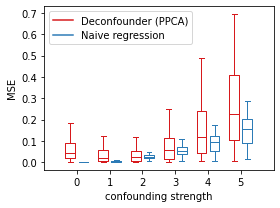

In [9]:
dcfs = []
naives = []
for Ucoef in [0,1,2,3,4,5]:
    print(Ucoef)
    dcferrs = []
    naiveerrs = []
    for _ in range(100):
        X, y, coef, intcpt = gen_uniformU(n,d,Ucoef)
        dcferr = dcf(X, y)
        naiveerr = naive(X, y)
        dcferrs.append(dcferr)
        naiveerrs.append(naiveerr)
#         print(dcferr, naiveerr, dcferr<naiveerr)
    print("conf strength", Ucoef, \
          "prob(DCFmse < NAIVEmse)", (np.array(dcferrs) < np.array(naiveerrs)).mean(), \
          "avgDCFmse", np.array(dcferrs).mean(), \
          "avgNAIVEmse", np.array(naiveerrs).mean())
    dcfs.append(dcferrs)
    naives.append(naiveerrs)
plot_dcf_naive(dcfs, naives, 'SEM_linear_simulation_uniformU.pdf')

In [10]:
# # evaluate predictability of Zhat given X
# pca = PCA(n_components=1)
# pca.fit(X)
# Zhat = pca.transform(X)
# x2 = sm.add_constant(X)
# models = sm.OLS(Zhat,x2)
# result = models.fit()

In [11]:
# print(result.summary())

In [12]:
# print((result.predict(x2) - Zhat.T).max())